In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install yfinance

In [ ]:

import yfinance as yf
from datetime import date, datetime
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, SimpleRNN
from tensorflow.keras.models import Sequential
import os
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None

In [ ]:
def create_dataset(X, y, time_steps=1):
    """
    Preprocess data
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
def plot_loss(history):
	"""Plot training & validation loss values"""
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('Model loss')
	plt.ylabel('Loss')
	plt.xlabel('Epoch')
	plt.legend(['Train', 'Test'], loc='upper left')
	plt.show()

In [ ]:
def build_model(timesteps, num_features):
    """Build LSTM model for prediction"""
    model = Sequential([
        LSTM(128, activation='relu', input_shape=(timesteps, num_features)),
        RepeatVector(timesteps),
        LSTM(128, activation='relu', return_sequences=True),
        Dropout(0.2),
        TimeDistributed(Dense(num_features))
    ])

    # This is not a classification problem, but a regression problem. We can't use accuracy.
    # We have to use mean squared error on each prediction.
    model.compile(loss='mean_squared_error', optimizer='adam')
    print(model.summary())
    return model

In [ ]:
def load_model(model_file_name):
    print("[INFO] loading {} model".format(model_file_name))
    json_file = open(model_file_name + ".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(model_file_name + ".h5")
    loaded_model.compile(loss='mae', optimizer='adam')
    return loaded_model


def save_model(model, model_file_name):
    print("[INFO] Saving {} model".format(model_file_name))
    model_json = model.to_json()
    with open(model_file_name + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_file_name + ".h5")

In [ ]:
def detect_anomaly(stock_price, time_steps=1, close_column_name="Adj Close"):
    X_train, y_train, X_test, y_test, train, test = plot_and_prepare_data(stock_price)

    # Train model
    model = train_model(X_train, y_train)

    # Evaluate model
    evaluate_model(model, X_test, y_test)

    THRESHOLD = 0.55

    test_mae_loss = calculate_mae_loss(model, X_test)
    print("[INFO] mae loss:", test_mae_loss)

    test_score_df = pd.DataFrame(test[time_steps:])
    test_score_df['loss'] = test_mae_loss
    test_score_df['threshold'] = THRESHOLD
    test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
    test_score_df[close_column_name] = test[time_steps:][close_column_name]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test[time_steps:].Date, y=test_score_df.loss,
                        mode='lines',
                        name='Test Loss'))
    fig.add_trace(go.Scatter(x=test[time_steps:].Date, y=test_score_df.threshold,
                        mode='lines',
                        name='Threshold'))
    fig.update_layout(showlegend=True)

    # Plot mean squared error
    plot_mae_loss(model, X_train)
    plot_mae_loss(model, X_test)

    fig.show()

    anomalies = test_score_df[test_score_df.anomaly == True]
    print("Anomaliler bunlar\n")
    print(anomalies.head())
    print("Anomali deneme \n",anomalies[close_column_name])
    print("Close price deneme \n",test[time_steps:][[close_column_name]])
    print("Anomalies date \n",anomalies.Date)
    print("test date \n",test[time_steps:].Date)
    scaler = StandardScaler()
    scaler = scaler.fit(train[[close_column_name]])

    train[close_column_name] = scaler.transform(train[[close_column_name]])
    test[close_column_name] = scaler.transform(test[[close_column_name]])
    """
    print("Anomaly grafik **************************")
    plt.plot(anomalies[close_column_name])
    plt.title("Anomalies Graph")
    plt.ylabel('values')
    plt.show()  
    print("close price grafik **************************")
    plt.plot(test[time_steps:][[close_column_name]])
    plt.title("Close Price Graph")
    plt.ylabel('values')
    plt.show()
    """
    print("Anomaly-Close Price grafik **************************")
    plt.figure(figsize =(10, 10))
    plt.plot(test[time_steps:].Date, test[time_steps:][[close_column_name]])
    #plt.scatter(test[time_steps:].Date, test[time_steps:][[close_column_name]], c = 'blue', label = 'Normal')
    plt.scatter(anomalies.Date, anomalies[[close_column_name]], c = 'red', label = 'Outlier') 
    plt.show()
    """
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=test[time_steps:].Date, y=scaler.inverse_transform(test[time_steps:][[close_column_name]]),
                        mode='lines',
                        name='Close Price'))
    fig2.add_trace(go.Scatter(x=test[time_steps:], y=scaler.inverse_transform(anomalies[[close_column_name]]),
                        mode='markers',
                        name='Anomaly'))
    fig2.update_layout(showlegend=True)
    fig2.show()
    """
    breakouts = pd.DataFrame(test[time_steps:])
    test_score_df['loss'] = test_mae_loss
    breakouts['threshold'] = THRESHOLD
    breakouts['anomaly'] = test_score_df.loss > test_score_df.threshold
    breakouts[close_column_name] = scaler.inverse_transform(test[time_steps:][[close_column_name]])
    print("breakouts bunlar \n ",breakouts.head())
    max_profit, profitable_trade_count, unprofitable_trade_count, success_rate = calc_max_profit_based_on_breakouts(breakouts, close_column_name)
    print("Toplam Anomali Sayısı = ",len(breakouts['anomaly']))
    return max_profit, profitable_trade_count, unprofitable_trade_count, success_rate

In [ ]:
def calc_max_profit_based_on_breakouts(breakouts, close_column_name="Adj Close", predictions_column_name="Predictions"):
    '''Calculate max profit given LSTM breakouts. 
    breakouts is a pandas dataframe and has
    ['Adj Close', 'Anomalies'].'''
    max_profit = 0
    profitable_trade_count = unprofitable_trade_count = 0
    for i in range(len(breakouts) - 1):
        if breakouts[close_column_name].iloc[i + 1] > breakouts[close_column_name].iloc[i] and breakouts["anomaly"].iloc[i] == True:
            # LSTM predicted a breakout successfully. Execute trade and collect profits.
            max_profit += breakouts[close_column_name].iloc[i + 1] - breakouts[close_column_name].iloc[i]
            profitable_trade_count +=1
        elif breakouts[close_column_name].iloc[i + 1] < breakouts[close_column_name].iloc[i] and breakouts["anomaly"].iloc[i] == True:
            # LSTM prediction of a breakout was NOT successful. Execute the trade to stop loss.
            # We have breakouts[close_column_name].iloc[i + 1] < breakouts[close_column_name].iloc[i], so here we are adding a negative value to max_profit.
            # This means we are losing money. 
            max_profit += breakouts[close_column_name].iloc[i + 1] - breakouts[close_column_name].iloc[i]
            unprofitable_trade_count +=1
        elif breakouts["anomaly"].iloc[i] == False:
            # LSTM predicts no breakout. We don't enter a trade.
            pass
    success_rate = profitable_trade_count / (profitable_trade_count + unprofitable_trade_count) * 100
    print("[INFO] Profitable trade count: {} Unprofitable trade count: {} Success Rate: {}%".format(profitable_trade_count, unprofitable_trade_count, success_rate))
    return max_profit, profitable_trade_count, unprofitable_trade_count, success_rate

In [ ]:
def fetch_data(ticker, start_date, end_date):
    """
    Downloads and writes the stock price data to csv.
    If the csv data already exists, read from it.
    """
    file_path = os.path.join("/content/drive/MyDrive/ML_Project2", ticker+".csv")
    if os.path.exists(file_path):
        return pd.read_csv(file_path, index_col=0)
    start_date_object = to_datetime(start_date)
    end_date_object = to_datetime(end_date)
    stock_price = yf.download(
        ticker, start_date=start_date_object, end_date=end_date_object)
    stock_price.to_csv(file_path)
    return pd.read_csv(file_path, index_col=0)

In [ ]:
def buy_and_hold(stock_price, start_date, end_date):
    """Calculate profit from buy and hold"""
    return stock_price.loc[end_date, 'Adj Close'] - stock_price.loc[start_date, 'Adj Close']


def to_datetime(date_str):
    temp = datetime.strptime(date_str, '%Y-%M-%d')
    return date(temp.year, temp.month, temp.day)


def calculate_mae_loss(model, X):
    X_pred = model.predict(X)
    mae_loss = np.mean(np.abs(X_pred - X), axis=1)
    print("[INFO] mae loss:", mae_loss)
    return mae_loss


def plot_mae_loss(model, X_train, bins=50, kde=True):
    X_train_pred = model.predict(X_train)
    train_mae_loss = pd.DataFrame(
        np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])
    sns.distplot(train_mae_loss, bins=bins, kde=kde)
    plt.show()

In [ ]:
def evaluate_model(model, X_test, y_test):
    print("[INFO] Model evaluation results:")
    print(model.evaluate(X_test, y_test))


def train_model(X_train, y_train, epochs=1):
    """Train model and plot loss and accuracy"""
    time_steps = X_train.shape[1]
    num_features = X_train.shape[2]

    # Fit model with early stopping
    model = build_model(time_steps, num_features)

    es = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3, mode='min')

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_split=0.1,
        callbacks=[es],
        shuffle=False
    )

    plot_loss(history)
    return model


In [ ]:
def plot_and_prepare_data(df, close_column_name="Adj Close"):

    # adapted from https://github.com/Tekraj15/AnomalyDetectionTimeSeriesData/blob/master/Anomaly_Detection_Time_Series_Keras.ipynb
    fig = go.Figure()
    print(df.head())
    fig.add_trace(go.Scatter(x=df.index, y=df[close_column_name],
                        mode='lines',
                        name=close_column_name))
    fig.update_layout(showlegend=True)
    fig.show()

    # creating a DataFrame
    my_df = {'Date': df.index,
            'Adj Close': df[close_column_name]}
    df = pd.DataFrame(my_df)
    df.reset_index(drop=True, inplace=True)
    print(df.head())

    train_size = int(len(df) * 0.8)
    test_size = len(df) - train_size
    train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
    print(train.shape, test.shape)

    scaler = StandardScaler()
    scaler = scaler.fit(train[[close_column_name]])

    train[close_column_name] = scaler.transform(train[[close_column_name]])
    test[close_column_name] = scaler.transform(test[[close_column_name]])

    time_steps = 30

    X_train, y_train = create_dataset(
        train[[close_column_name]], train[close_column_name], time_steps)
    X_test, y_test = create_dataset(
        test[[close_column_name]], test[close_column_name], time_steps)

    print(X_train.shape)
    return X_train, y_train, X_test, y_test, train, test

In [ ]:
def plot_data(df, close_column_name="Adj Close"):
    from copy import deepcopy
    df = deepcopy(df)
    my_df = {'Date': df.index,
            'Adj Close': df[close_column_name]}
    df = pd.DataFrame(my_df)
    df.reset_index(drop=True, inplace=True)
    df.plot(x='Date', y=close_column_name)
    plt.title('Close Price History', fontsize=18)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.show()

In [ ]:
def trade_pure_lstm_predictions(df, close_column_name="Adj Close"):
    plot_data(df, close_column_name=close_column_name)
    # Create a new dataframe with only the 'Close column
    data = df.filter([close_column_name])

    # Convert the dataframe to a numpy array
    dataset = data.values
    # Get the number of rows to train the model on
    training_data_len = int(np.ceil(len(dataset) * .8))

    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    # Create the training data set
    # Create the scaled training data set
    train_data = scaled_data[0:int(training_data_len), :]
    # Split the data into x_train and y_train data sets
    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
        if i <= 61:
            print(x_train)
            print(y_train)
            print()

    # Convert the x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    from keras.models import Sequential
    from keras.layers import Dense, LSTM

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True,
              input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model
    try:
        load_model('lstm-price-predictor')
    except Exception as e:
        history = model.fit(x_train, y_train, batch_size=1, epochs=2)
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Epoch')
    plt.legend('Train', loc='upper left')
    plt.show()
    save_model(model, 'lstm-price-predictor')

    # Create the testing data set
    # Create a new array containing scaled values from index 1543 to 2002
    test_data = scaled_data[training_data_len - 60:, :]
    # Create the data sets x_test and y_test
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    # Convert the data to a numpy array
    x_test = np.array(x_test)

    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Get the models predicted price values
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    # Plot error
    plot_error(y_test, predictions)
    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print("[INFO] Test dataset final RMSE value:{}".format(rmse))
    # Plot the data
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions
    # Visualize the data
    my_df = {'Date': train.index,
            'Adj Close': train[close_column_name]}
    train = pd.DataFrame(my_df)
    train["Date"] = pd.to_datetime(train["Date"])
    train.reset_index(drop=True, inplace=True)

    my_df = {'Date': valid.index, 'Close': valid[close_column_name], 'Predictions': valid['Predictions']}
    valid = pd.DataFrame(my_df)
    valid["Date"] = pd.to_datetime(valid["Date"])
    valid.reset_index(drop=True, inplace=True)
    
    # Visualize the data
    plt.figure(figsize=(16,8))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)

    plt.plot(train['Date'], train[close_column_name])
    plt.plot(valid['Date'], valid[[close_column_name, 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()
    max_profit, profitable_trade_count, unprofitable_trade_count, success_rate = calc_max_profit(valid)
    return max_profit, profitable_trade_count, unprofitable_trade_count, success_rate

In [ ]:
def plot_error(y_test, predictions, bins=50, kde=True):
    error = pd.DataFrame(
        np.mean(np.abs(predictions - y_test), axis=1), columns=['Error'])
    sns.distplot(error, bins=bins, kde=kde)
    plt.show()

def calc_max_profit(valid, close_column_name="Adj Close", predictions_column_name="Predictions"):
    '''Calculate max profit given LSTM predictions. 
    valid is a pandas dataframe and has
    ['Adj Close', 'Predictions'].'''
    max_profit = 0
    profitable_trade_count = unprofitable_trade_count = 0
    for i in range(len(valid) - 1):
        if valid[close_column_name].iloc[i + 1] > valid[close_column_name].iloc[i] and valid[predictions_column_name].iloc[i + 1] > valid[predictions_column_name].iloc[i]:
            # LSTM prediction was succesful. Execute trade and collect profits.
            max_profit += valid[close_column_name].iloc[i + 1] - valid[close_column_name].iloc[i]
            profitable_trade_count +=1
        elif valid[close_column_name].iloc[i + 1] < valid[close_column_name].iloc[i] and valid[predictions_column_name].iloc[i + 1] > valid[predictions_column_name].iloc[i]:
            # LSTM prediction was NOT successful. Execute the trade to stop loss.
            # We have valid[close_column_name].iloc[i + 1] < valid[close_column_name].iloc[i], so here we are adding a negative value to max_profit.
            # This means we are losing money. 
            max_profit += valid[close_column_name].iloc[i + 1] - valid[close_column_name].iloc[i]
            unprofitable_trade_count +=1
        elif valid[predictions_column_name].iloc[i + 1] < valid[predictions_column_name].iloc[i]:
            # LSTM predicts that stock price will drop. We don't enter a trade.
            pass
    success_rate = profitable_trade_count / (profitable_trade_count + unprofitable_trade_count) * 100
    print("[INFO] Profitable trade count: {} Unprofitable trade count: {} Success Rate: {}%".format(profitable_trade_count, unprofitable_trade_count, success_rate))
    return max_profit, profitable_trade_count, unprofitable_trade_count, success_rate


In [ ]:
def run_pipeline(ticker="SPY", start_date="2002-02-13", end_date = "2021-02-12"):
    """For a given stock ticker, 
    i)  calculate and report profit from buy and hold (see buy_and_hold), 
    ii) calculate and report from LSTM predictions-based trading (see trade_pure_lstm_predictions)
    iii) calculate and report profit from anomaly detection-based trading (see detect_anomaly)
    No more than 1 share is bought/sold at a time.
    No shorting allowed. i.e we can only sell if we have a share.
    """
    print("[INFO] Pipeline started for Ticker:{} Start date:{} End date:{}".format(ticker, start_date, end_date))

    stock_price = fetch_data(ticker, start_date, end_date)
    # buy_and_hold_profit = buy_and_hold(stock_price, start_date, end_date)
    # print("[INFO] Buy and Hold profit is ${}".format(buy_and_hold_profit))

    #lstm_based_strategy_profit, _, _, _ = trade_pure_lstm_predictions(stock_price)
    # print("[INFO] Pure LSTM-based trading profit is ${}".format(lstm_based_strategy_profit))

    consolidation_breakout_profit, _, _, _= detect_anomaly(stock_price, time_steps = 30)
    print("[INFO] Consolidation Breakout trading profit is ${}".format(consolidation_breakout_profit))

In [ ]:
def my_run_pipeline(df):
  #lstm_based_strategy_profit, _, _, _ = trade_pure_lstm_predictions(df)
  consolidation_breakout_profit, _, _, _= detect_anomaly(df, time_steps = 30)
  print("[INFO] Consolidation Breakout trading profit is ${}".format(consolidation_breakout_profit))

[INFO] Pipeline started for Ticker:SPY Start date:2002-02-13 End date:2021-02-12
                Open      High       Low     Close  Adj Close   Volume
Date                                                                  
1993-01-29  43.96875  43.96875  43.75000  43.93750  25.968958  1003200
1993-02-01  43.96875  44.25000  43.96875  44.25000  26.153660   480500
1993-02-02  44.21875  44.37500  44.12500  44.34375  26.209057   201300
1993-02-03  44.40625  44.84375  44.37500  44.81250  26.486113   529400
1993-02-04  44.96875  45.09375  44.46875  45.00000  26.596937   531500


         Date  Adj Close
0  1993-01-29  25.968958
1  1993-02-01  26.153660
2  1993-02-02  26.209057
3  1993-02-03  26.486113
4  1993-02-04  26.596937
(5649, 2) (1413, 2)
(5619, 30, 1)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 128)               66560     
                                                                 
 repeat_vector_5 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_11 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_5 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_5 (TimeDis  (None, 30, 1)            129       
 t

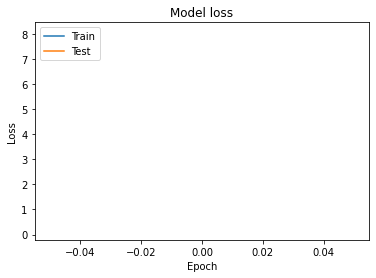

[INFO] Model evaluation results:
44/44 [==============================] - 1s 18ms/step - loss: 306040.8125
306040.8125
[INFO] mae loss: [[   6.77220611]
 [   6.80649105]
 [   6.87148912]
 ...
 [1058.78044878]
 [1073.78811007]
 [ 582.69871928]]
[INFO] mae loss: [[   6.77220611]
 [   6.80649105]
 [   6.87148912]
 ...
 [1058.78044878]
 [1073.78811007]
 [ 582.69871928]]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



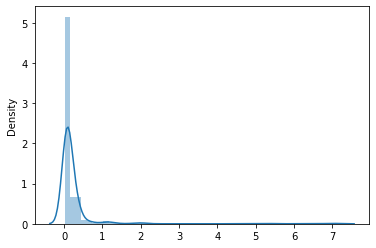

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



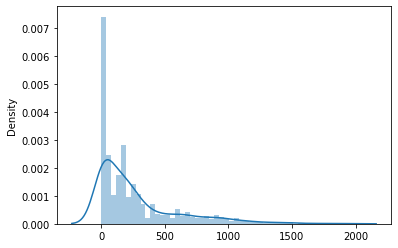

Anomaliler bunlar

            Date  Adj Close      loss  threshold  anomaly
5679  2015-08-18   2.744496  6.772206       0.55     True
5680  2015-08-19   2.704526  6.806491       0.55     True
5681  2015-08-20   2.599782  6.871489       0.55     True
5682  2015-08-21   2.451937  6.897162       0.55     True
5683  2015-08-24   2.251358  6.850302       0.55     True
Anomali deneme 
 5679    2.744496
5680    2.704526
5681    2.599782
5682    2.451937
5683    2.251358
          ...   
7057    8.160737
7058    8.153765
7059    8.149205
7060    8.166100
7061    8.217858
Name: Adj Close, Length: 1383, dtype: float64
Close price deneme 
       Adj Close
5679   2.744496
5680   2.704526
5681   2.599782
5682   2.451937
5683   2.251358
...         ...
7057   8.160737
7058   8.153765
7059   8.149205
7060   8.166100
7061   8.217858

[1383 rows x 1 columns]
Anomalies date 
 5679    2015-08-18
5680    2015-08-19
5681    2015-08-20
5682    2015-08-21
5683    2015-08-24
           ...    
7057    2021-0

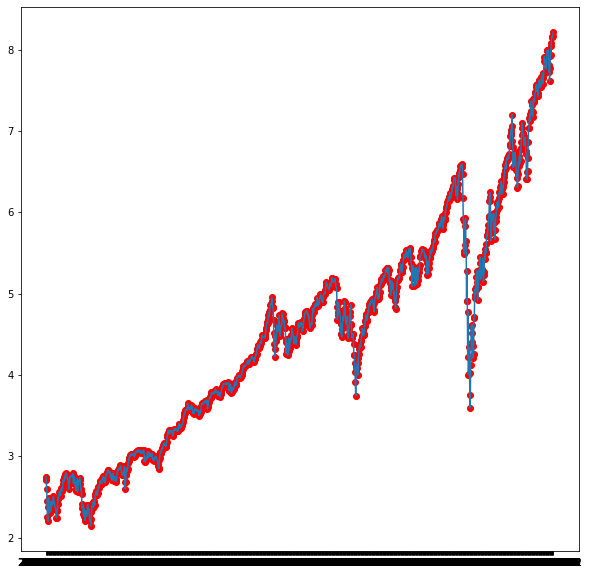

breakouts bunlar 
              Date  Adj Close  threshold  anomaly
5679  2015-08-18   2.744496       0.55     True
5680  2015-08-19   2.704526       0.55     True
5681  2015-08-20   2.599782       0.55     True
5682  2015-08-21   2.451937       0.55     True
5683  2015-08-24   2.251358       0.55     True
[INFO] Profitable trade count: 772 Unprofitable trade count: 606 Success Rate: 56.02322206095791%
Toplam Anomali Sayısı =  1383
[INFO] Consolidation Breakout trading profit is $5.473362001248909


In [ ]:
if __name__ == "__main__":

    #run_pipeline(ticker="SPY", start_date="2002-02-13", end_date = "2021-02-12")
    my_run_pipeline()